In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import yahist
from utils import make_table_1D, make_table_2D, write_tool

In [2]:
DEBUG = False
FUNC_NAMES = []
TTH_SFS_BASE = "data/lepton_scalefactors"

# 1. Utilities
## 1.1 ROOT I/O

In [3]:
def get_hist_1D(input_file, hist_name):
    hist = uproot.open(input_file).get(hist_name)
    (bin_counts, bin_edges) = hist.numpy()
    return bin_counts, bin_edges

def get_hist_2D(input_file, hist_name):
    hist = uproot.open(input_file).get(hist_name)
    (bin_counts, bin_edges) = hist.numpy()
    x_bin_edges, y_bin_edges = bin_edges[0]
    return bin_counts, x_bin_edges, y_bin_edges

## 1.2 Plotting

In [4]:
def bin_text(counts, x_edges, y_edges, axes, cbar, size=8, fmt=":g"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2

    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, z), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            ("{"+fmt+"}").format(z),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return


def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

## 1.3 Miscellaneous

In [5]:
def get_sf_cpp(input_files, hist_name, func_name, debug=True, write_mode="w", err=False,
               years=["2016", "2017", "2018"]):
    # Set up sanity-check plots
    if not err:
        fig, axes = plt.subplots(1, 3, figsize=(36, 9))
    # Write function name
    all_cpp = f"\nfloat ttH::{func_name}(float eta, float pt, int year) {{\n"
    # Get C++ table for Run2
    for i, input_file in enumerate(input_files):
        year = years[i]
        # Get tight ID sf histogram
        hist = uproot.open(input_file).get(hist_name)
        # Make tables
        cpp = make_table_2D(
            np.sqrt(hist.variances) if err else hist.values, 
            hist.edges[0], hist.edges[1], 
            y_overflow=True, x_abs=True,
            x_name="eta", y_name="pt"
        )
        # Indent C++ code
        cpp = "\n".join(["    "+line for line in cpp.split("\n")])
        # Append to main function
        all_cpp += "\n".join([f"    if (year == {year}) {{"]+cpp.split("\n")[2:-3]+["    }", ""])
        # Plot for sanity check
        if not err:
            ax = axes[i]
            c = ax.pcolorfast(hist.edges[0], hist.edges[1], hist.values.T)
            cbar = fig.colorbar(c, ax=ax)
            bin_text(hist.values.T, hist.edges[0], hist.edges[1], ax, cbar, fmt=":0.3f")
            ax.set_title(year, size=18)
    # Add a default return value and wrap up
    all_cpp += "    return 0.0;\n"
    all_cpp += "}\n"
    # Print final C++ table
    print(all_cpp)
    # Write to file
    if not debug:
        write_tool(all_cpp, writemode=write_mode, name="lepScaleFactors")
    return all_cpp

def get_tth_err_cpp(input_files, hist_name, func_name, debug=True, write_mode="w", err=False,
                    years=["2016", "2017", "2018"], var="pt"):
    # Write function name
    all_cpp = f"\nfloat ttH::{func_name}(float {var}, int year) {{\n"
    # Get C++ table for Run2
    for i, input_file in enumerate(input_files):
        year = years[i]
        # Get tight ID sf histogram
        hist = uproot.open(input_file).get(hist_name)
        # Make tables
        cpp = make_table_1D(
            hist.values, 
            hist.edges,
            x_name=var,
            x_abs=(var == "eta"),
            overflow=(var == "pt")
        )
        # Indent C++ code
        cpp = "\n".join(["    "+line for line in cpp.split("\n")])
        # Append to main function
        all_cpp += "\n".join([f"    if (year == {year}) {{"]+cpp.split("\n")[2:-3]+["    }", ""])
    # Add a default return value and wrap up
    all_cpp += "    return 0.0;\n"
    all_cpp += "}\n"
    # Print final C++ table
    print(all_cpp)
    # Write to file
    if not debug:
        write_tool(all_cpp, writemode=write_mode, name="lepScaleFactors")
    return all_cpp

# 2. Tight ttH lepton ID
## 2.1 Electrons


float ttH::getElecTightSF(float eta, float pt, int year) {
    if (year == 2016) {
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 15) return 0.755435;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 15 && pt < 20) return 0.823245;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.829126;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.83156;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.831597;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.837012;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.84375;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.855784;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.87156;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 0.893871;
        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >= 10 

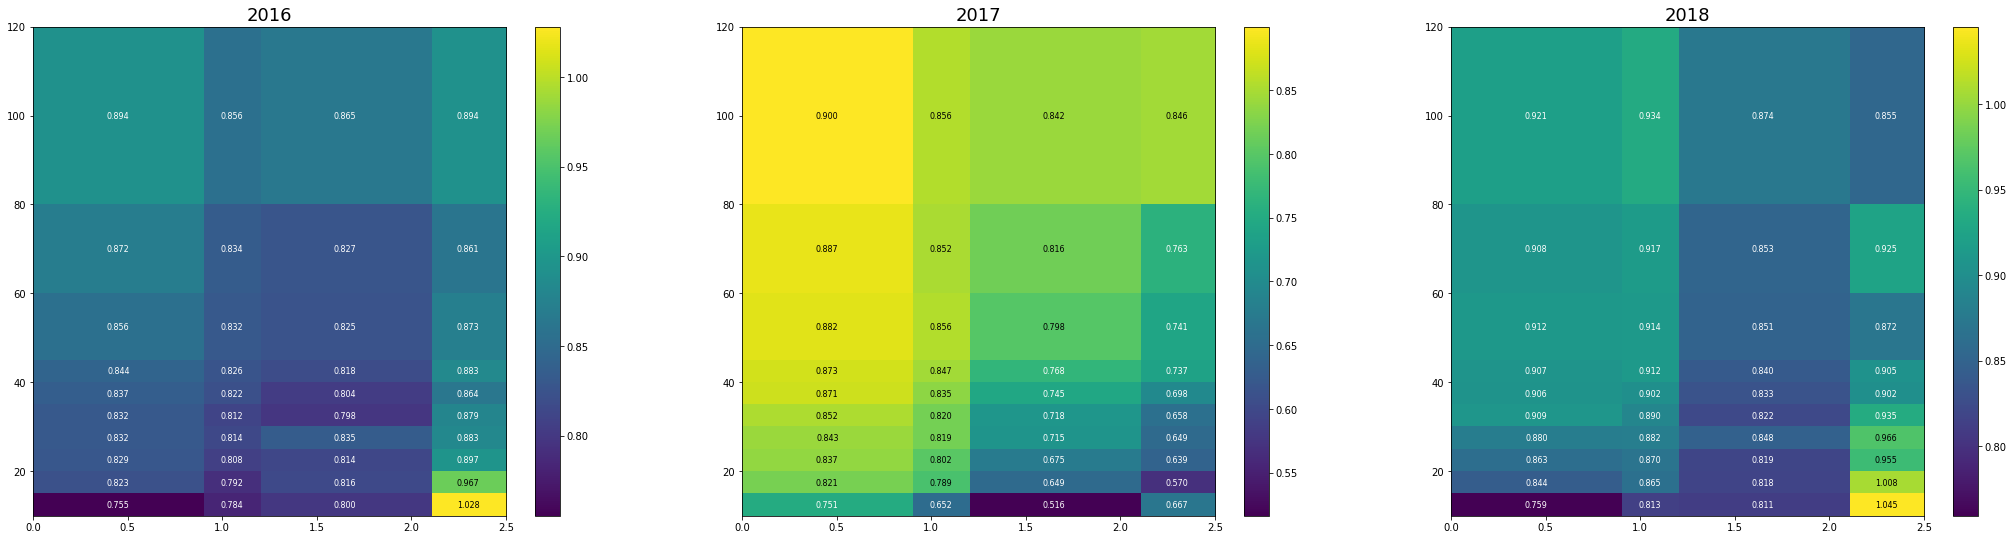

In [6]:
input_files = [f"{TTH_SFS_BASE}/{year}/electrons/tight/sf/egammaEffi.txt_EGM2D.root" 
               for year in ["2016", "2017", "2018"]]
get_sf_cpp(input_files, "EGamma_SF2D", "getElecTightSF", debug=DEBUG, write_mode="w");

In [7]:
input_files = [f"{TTH_SFS_BASE}/{year}/electrons/tight/err/SFttbar_{year}_ele_pt.root" 
               for year in ["2016", "2017", "2018"]]
get_tth_err_cpp(input_files, "histo_eff_data", "getElecTTHSFErrPt", debug=DEBUG, err=False,
                years=["2016", "2017", "2018"], var="pt", write_mode="a")

input_files = [f"{TTH_SFS_BASE}/{year}/electrons/tight/err/SFttbar_{year}_ele_eta.root" 
               for year in ["2016", "2017", "2018"]]
get_tth_err_cpp(input_files, "histo_eff_data", "getElecTTHSFErrEta", debug=DEBUG, err=False,
                years=["2016", "2017", "2018"], var="eta", write_mode="a")

cpp = """
float ttH::getElecTTHSFErr(float eta, float pt, int year, bool up) {
    float max_err = max(ttH::getElecTTHSFErrPt(pt, year), ttH::getElecTTHSFErrEta(eta, year));
    return (1.0 - max_err);
}"""

print(cpp)
if not DEBUG:
    write_tool(cpp, writemode="a", name="lepScaleFactors")


float ttH::getElecTTHSFErrPt(float pt, int year) {
    if (year == 2016) {
        if (pt >= 0 && pt < 15) return 0.967409;
        if (pt >= 15 && pt < 30) return 0.953719;
        if (pt >= 30 && pt < 45) return 1.00114;
        if (pt >= 45 && pt < 60) return 0.998463;
        if (pt >= 60 && pt < 75) return 1.00979;
        if (pt >= 75 && pt < 90) return 0.993269;
        if (pt >= 90 && pt < 105) return 0.986654;
        if (pt >= 105 && pt < 120) return 0.988112;
        if (pt >= 120 && pt < 135) return 1.0086;
        if (pt >= 135) return 1.00871;
    }
    if (year == 2017) {
        if (pt >= 0 && pt < 15) return 1.02674;
        if (pt >= 15 && pt < 30) return 1.02898;
        if (pt >= 30 && pt < 45) return 1.04209;
        if (pt >= 45 && pt < 60) return 1.01939;
        if (pt >= 60 && pt < 75) return 1.02722;
        if (pt >= 75 && pt < 90) return 1.01655;
        if (pt >= 90 && pt < 105) return 1.01922;
        if (pt >= 105 && pt < 120) return 1.01626;
        if 

## 2.2 Muons


float ttH::getMuonTightSF(float eta, float pt, int year) {
    if (year == 2016) {
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 15) return 0.955882;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 15 && pt < 20) return 0.976574;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.985401;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.989933;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.995731;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.995851;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.998979;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.998987;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.998992;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 1.00302;
        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >= 1

'\nfloat ttH::getMuonTightSF(float eta, float pt, int year) {\n    if (year == 2016) {\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 15) return 0.955882;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 15 && pt < 20) return 0.976574;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.985401;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.989933;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.995731;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.995851;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.998979;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.998987;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.998992;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 1.00302;\n        if (fabs(eta) >= 0.9 && fabs(eta) < 

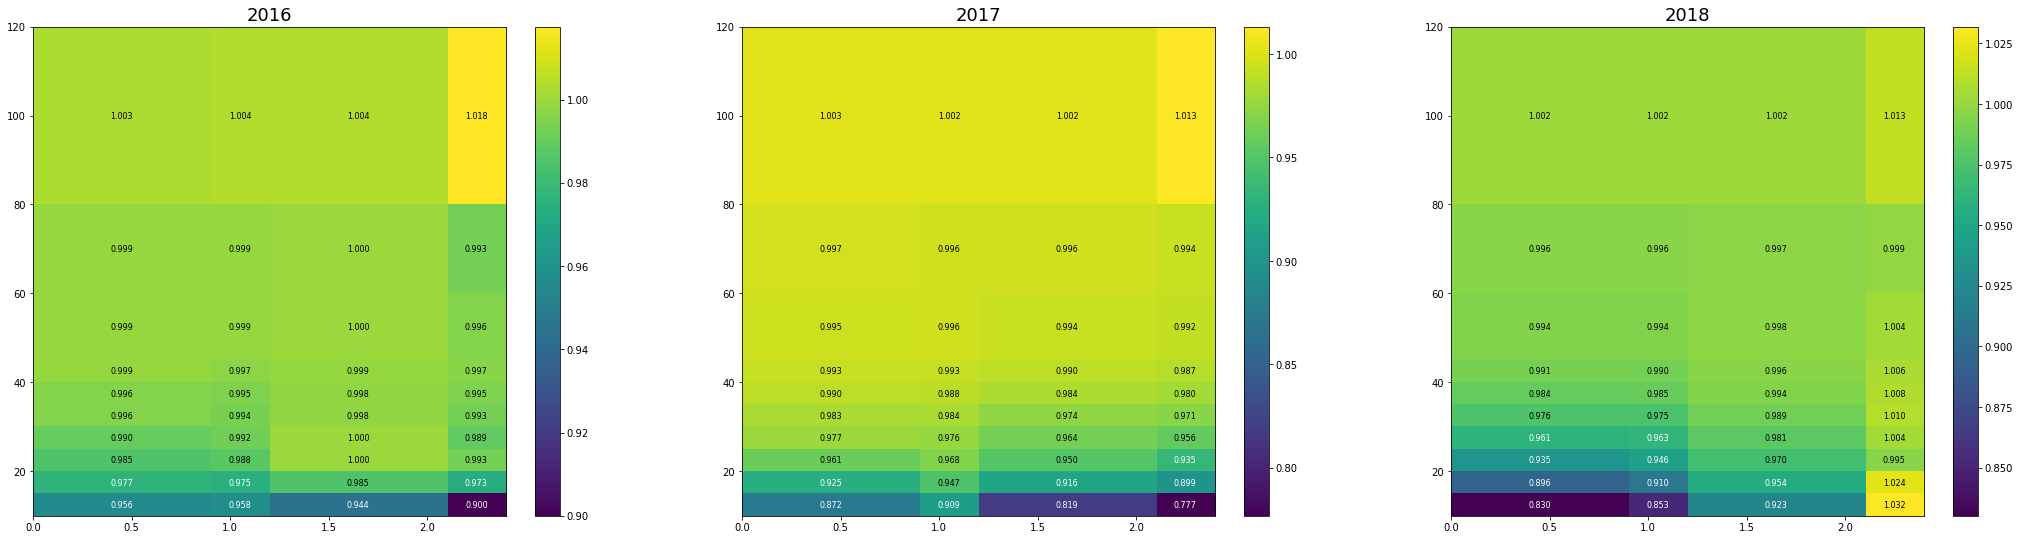

In [8]:
input_files = [f"{TTH_SFS_BASE}/{year}/muons/tight/sf/egammaEffi.txt_EGM2D.root" 
               for year in ["2016", "2017", "2018"]]
get_sf_cpp(input_files, "EGamma_SF2D", "getMuonTightSF", debug=DEBUG, write_mode="a")

In [9]:
input_files = [f"{TTH_SFS_BASE}/{year}/muons/tight/err/SFttbar_{year}_muon_pt.root" 
               for year in ["2016", "2017", "2018"]]
get_tth_err_cpp(input_files, "histo_eff_data", "getMuonTTHSFErrPt", debug=DEBUG, err=False,
                years=["2016", "2017", "2018"], var="pt", write_mode="a")

input_files = [f"{TTH_SFS_BASE}/{year}/muons/tight/err/SFttbar_{year}_muon_eta.root" 
               for year in ["2016", "2017", "2018"]]
get_tth_err_cpp(input_files, "histo_eff_data", "getMuonTTHSFErrEta", debug=DEBUG, err=False,
                years=["2016", "2017", "2018"], var="eta", write_mode="a")

cpp = """
float ttH::getMuonTTHSFErr(float eta, float pt, int year, bool up) {
    float max_err = max(ttH::getMuonTTHSFErrPt(pt, year), ttH::getMuonTTHSFErrEta(eta, year));
    return (1.0 - max_err);
}"""

print(cpp)
if not DEBUG:
    write_tool(cpp, writemode="a", name="lepScaleFactors")


float ttH::getMuonTTHSFErrPt(float pt, int year) {
    if (year == 2016) {
        if (pt >= 0 && pt < 15) return 0.944572;
        if (pt >= 15 && pt < 30) return 0.984619;
        if (pt >= 30 && pt < 45) return 1.00288;
        if (pt >= 45 && pt < 60) return 0.997416;
        if (pt >= 60 && pt < 75) return 1.00684;
        if (pt >= 75 && pt < 90) return 1.00068;
        if (pt >= 90 && pt < 105) return 0.988714;
        if (pt >= 105 && pt < 120) return 0.996859;
        if (pt >= 120 && pt < 135) return 1.00141;
        if (pt >= 135) return 0.990344;
    }
    if (year == 2017) {
        if (pt >= 0 && pt < 15) return 1.0035;
        if (pt >= 15 && pt < 30) return 0.9748;
        if (pt >= 30 && pt < 45) return 1.00079;
        if (pt >= 45 && pt < 60) return 0.998123;
        if (pt >= 60 && pt < 75) return 1.00255;
        if (pt >= 75 && pt < 90) return 1.00035;
        if (pt >= 90 && pt < 105) return 1.0018;
        if (pt >= 105 && pt < 120) return 0.998739;
        if 

# 3. Loose ttH lepton ID
## 3.1 Electrons


float ttH::getElecLooseSF(float eta, float pt, int year) {
    if (year == 2016) {
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 15) return 0.993704;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 15 && pt < 20) return 0.991667;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.990683;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.989765;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.991878;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.991911;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.990891;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.989879;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.987842;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 0.987854;
        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >= 

'\nfloat ttH::getElecLooseSF(float eta, float pt, int year) {\n    if (year == 2016) {\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 15) return 0.993704;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 15 && pt < 20) return 0.991667;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.990683;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.989765;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.991878;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.991911;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.990891;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.989879;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.987842;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 0.987854;\n        if (fabs(eta) >= 0.9 && fabs(eta) <

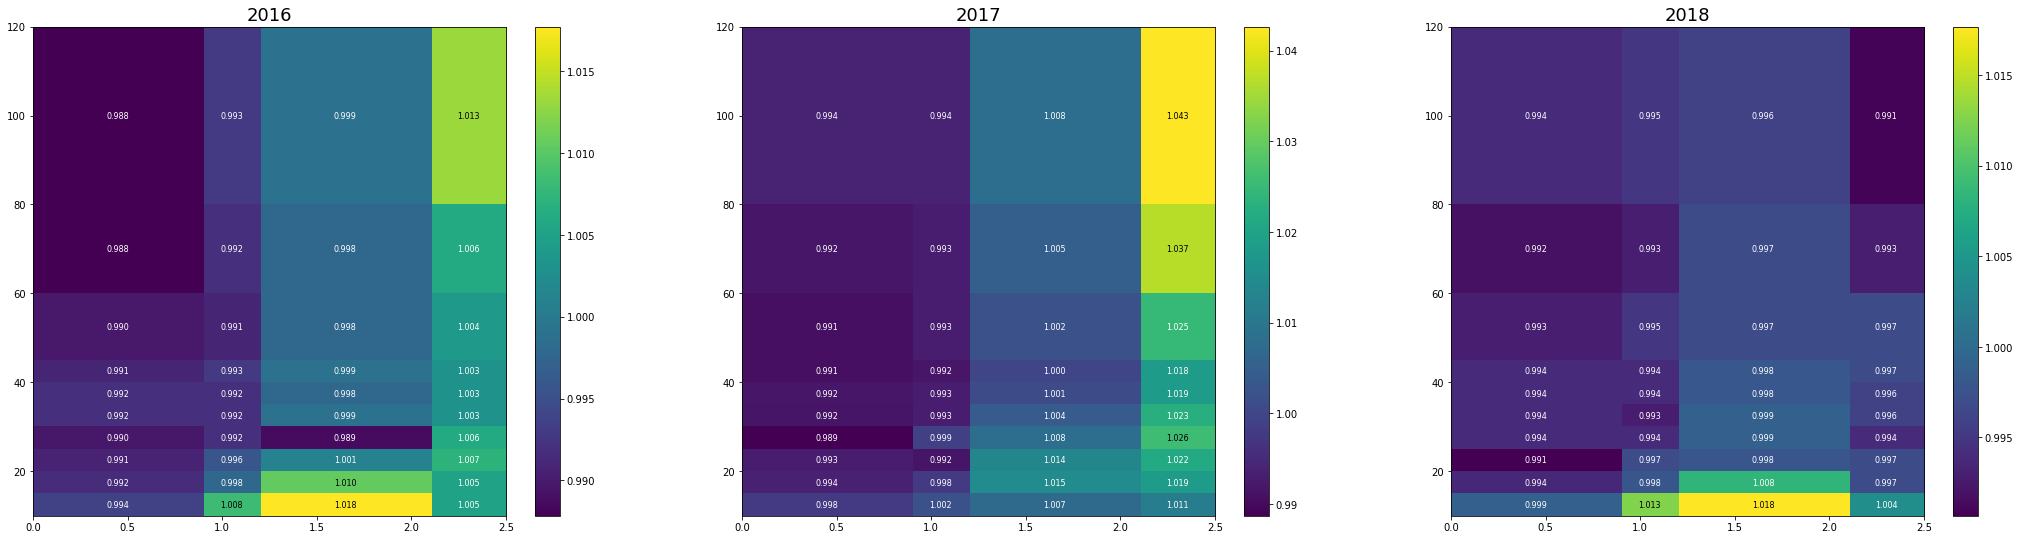

In [10]:
input_files = [f"{TTH_SFS_BASE}/{year}/electrons/loose/TnP_loosettH_ele_{year}.root" 
               for year in ["2016", "2017", "2018"]]
get_sf_cpp(input_files, "EGamma_SF2D", "getElecLooseSF", debug=DEBUG, write_mode="a")

## 3.2 Muons


float ttH::getMuonLooseSF(float eta, float pt, int year) {
    if (year == 2016) {
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 15) return 0.994571;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 15 && pt < 20) return 0.990374;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.991597;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.991761;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.994914;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.993933;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.993946;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.994955;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.99495;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 0.99798;
        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >= 10

'\nfloat ttH::getMuonLooseSF(float eta, float pt, int year) {\n    if (year == 2016) {\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 15) return 0.994571;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 15 && pt < 20) return 0.990374;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.991597;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.991761;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.994914;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.993933;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.993946;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.994955;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.99495;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 0.99798;\n        if (fabs(eta) >= 0.9 && fabs(eta) < 1

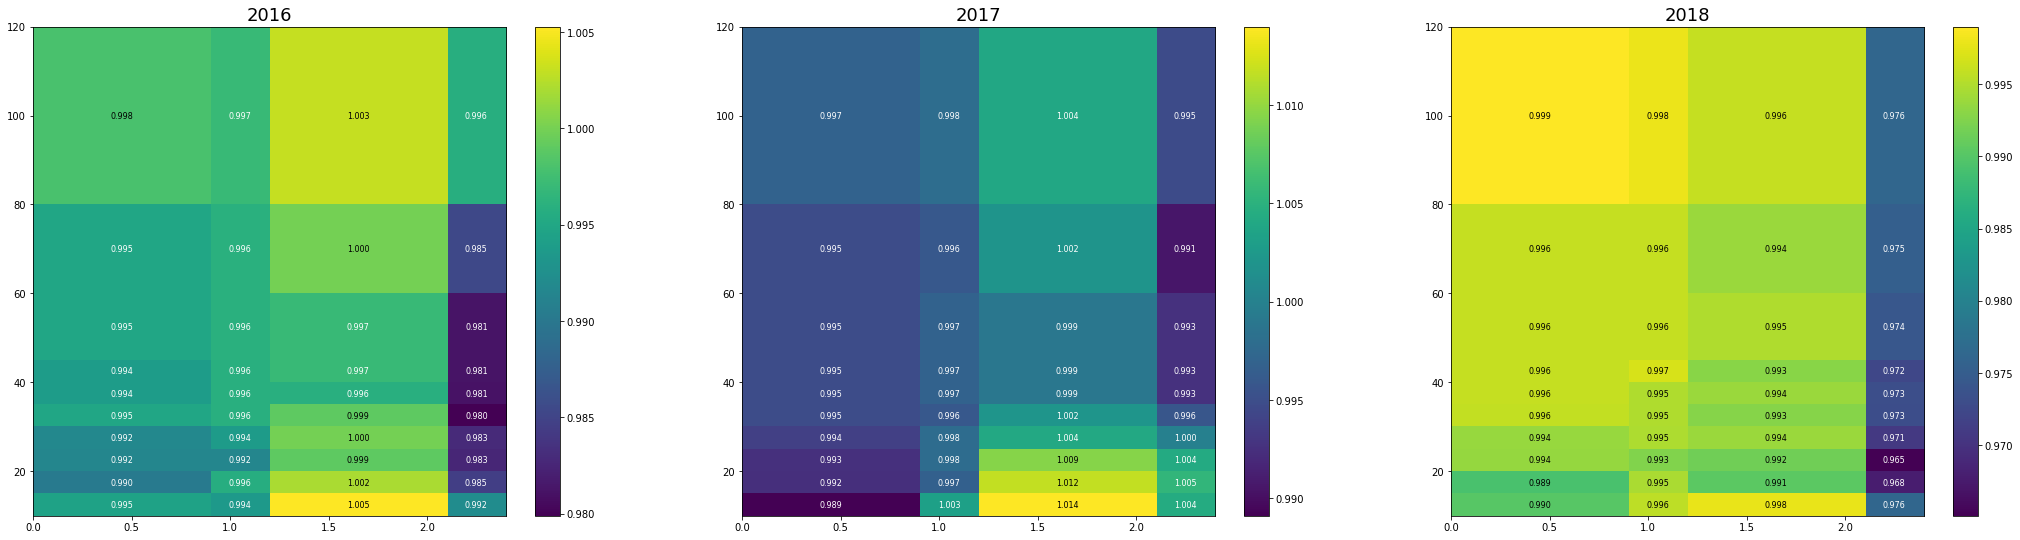

In [11]:
input_files = [f"{TTH_SFS_BASE}/{year}/muons/loose/TnP_loose_muon_{year}.root" 
               for year in ["2016", "2017", "2018"]]
get_sf_cpp(input_files, "EGamma_SF2D", "getMuonLooseSF", debug=DEBUG, write_mode="a")

# 4. Loose POG electron ID


float ttH::getElecPOGLooseSF(float eta, float pt, int year) {
    if (year == 2016) {
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 20) return 0.968097;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.971014;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.990798;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.991886;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.992929;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.993952;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.993958;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.994955;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 1.00202;
        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >= 10 && pt < 20) return 1.0426;
        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >

'\nfloat ttH::getElecPOGLooseSF(float eta, float pt, int year) {\n    if (year == 2016) {\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 20) return 0.968097;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.971014;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.990798;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.991886;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.992929;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.993952;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.993958;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.994955;\n        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 1.00202;\n        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >= 10 && pt < 20) return 1.0426;\n        if (fabs(eta) >= 0.9 && fabs(eta)

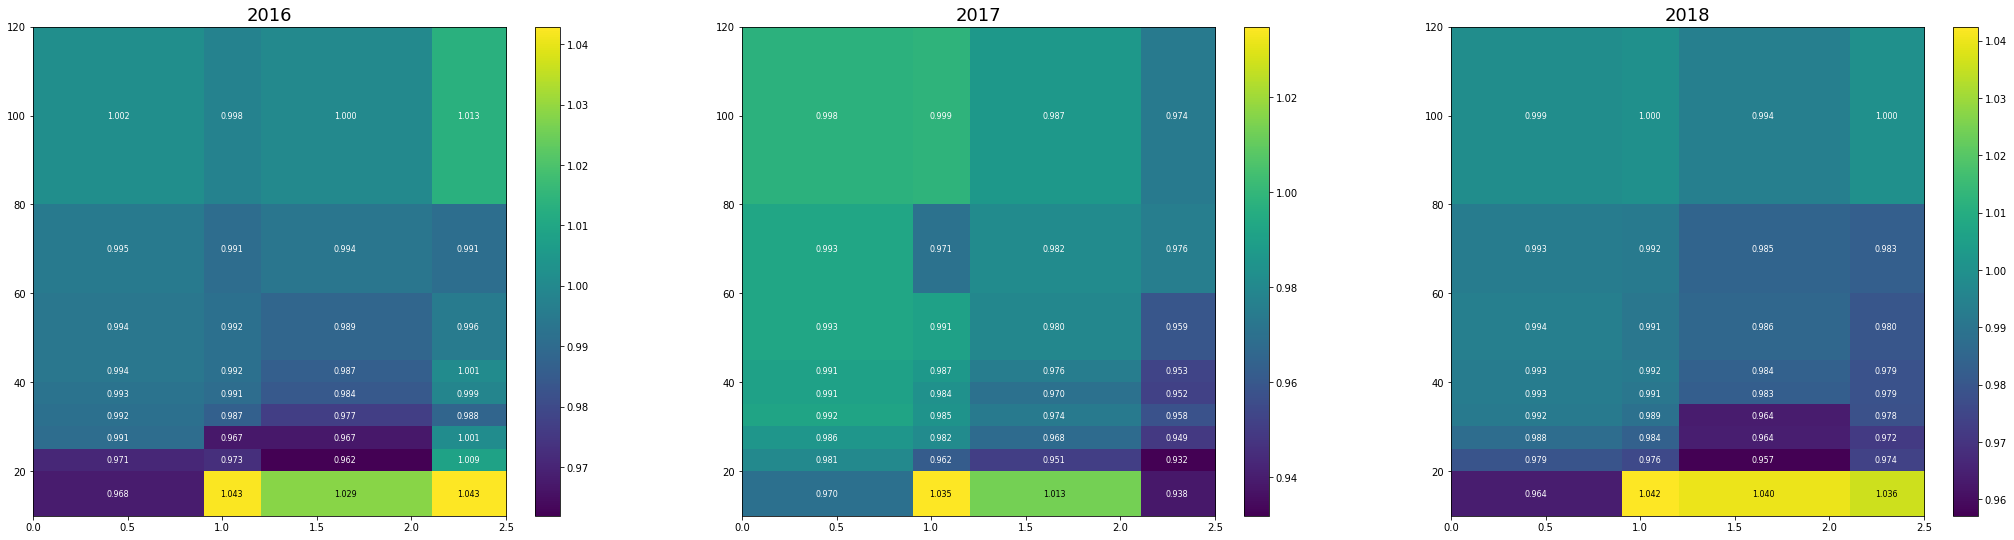

In [12]:
input_files = [f"{TTH_SFS_BASE}/{year}/electrons/pog/TnP_loose_ele_{year}.root" 
               for year in ["2016", "2017", "2018"]]
get_sf_cpp(input_files, "EGamma_SF2D", "getElecPOGLooseSF", debug=DEBUG, write_mode="a")

In [13]:
input_files = [f"{TTH_SFS_BASE}/{year}/electrons/pog/TnP_loose_ele_{year}.root" 
               for year in ["2016", "2017", "2018"]]
get_sf_cpp(input_files, "EGamma_SF2D", "getElecPOGLooseSFErr", debug=DEBUG, write_mode="a", err=True);


float ttH::getElecPOGLooseSFErr(float eta, float pt, int year) {
    if (year == 2016) {
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 10 && pt < 20) return 0.0260101;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 20 && pt < 25) return 0.0445375;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 25 && pt < 30) return 0.0307089;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 30 && pt < 35) return 0.0102429;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 35 && pt < 40) return 0.00247423;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 40 && pt < 45) return 0.00174602;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 45 && pt < 60) return 0.00174426;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 60 && pt < 80) return 0.00174778;
        if (fabs(eta) >= 0 && fabs(eta) < 0.9 && pt >= 80) return 0.00174955;
        if (fabs(eta) >= 0.9 && fabs(eta) < 1.2 && pt >= 10 && pt < 20) return 0.00910767;
        if (fabs(eta) >= 0.9 && f

# 5. Electron reconstruction

In [14]:
def get_reco_eff(func_name, debug=True, write_mode="w", err=False):
    global TTH_SFS_BASE
    # Write function name
    all_cpp = f"\nfloat ttH::{func_name}(float eta, float pt, int year) {{\n"
    # Get C++ table for 2016 and 2017
    for i, year in enumerate(["2016", "2017"]):
        cpp = ""
        for pt_bin in ["ptLt20", "ptGt20"]:
            # Get reco eff sf histogram (2016 and 2017 have two histograms)
            input_file = f"{TTH_SFS_BASE}/{year}/electrons/reco/el_scaleFactors_gsf_{pt_bin}.root"
            hist_name = "EGamma_SF2D"
            hist = uproot.open(input_file).get(hist_name)
            # Make tables
            _cpp = make_table_2D(
                np.sqrt(hist.variances) if err else hist.values, 
                hist.edges[0], hist.edges[1], 
                y_overflow=(pt_bin == "ptGt20"),
                x_name="eta", y_name="pt"
            )
            # Indent C++ code and strip original function
            cpp += "\n".join(["    "+line for line in _cpp.split("\n")[2:-3]])
            if pt_bin == "ptLt20":
                cpp += "\n"
        # Append to main function
        all_cpp += "\n".join([f"    if (year == {year}) {{"]+cpp.split("\n")+["    }", ""])

    # Get reco eff sf histogram (2018 only has one histogram)
    file_name = f"{TTH_SFS_BASE}/2018/electrons/reco/el_scaleFactors_gsf.root",
    hist_name = "EGamma_SF2D"
    hist = uproot.open(input_file).get(hist_name)
    # Make tables
    cpp = make_table_2D(
        np.sqrt(hist.variances) if err else hist.values, 
        hist.edges[0], hist.edges[1], 
        y_overflow=True, x_abs=True,
        x_name="eta", y_name="pt"
    )
    # Indent C++ code
    cpp = "\n".join(["    "+line for line in cpp.split("\n")])
    # Append to main function
    all_cpp += "\n".join([f"    if (year == 2018) {{"]+cpp.split("\n")[2:-3]+["    }", ""])

    # Add a default return value and wrap up
    all_cpp += "    return 0.0;\n"
    all_cpp += "}\n"
    # Print final C++ table
    print(all_cpp)
    # Write to file
    if not debug:
        write_tool(all_cpp, writemode=write_mode, name="lepScaleFactors")
    return all_cpp
    
def get_reco_UL_eff(func_name, debug=True, write_mode="w", err=False):
    global TTH_SFS_BASE
    
    # Write a separate function for pre- and post-VFP
    for pVFP in ["preVFP", "postVFP"]:
        all_cpp = f"\nfloat ttH::{func_name}2016{pVFP}(float eta, float pt) {{\n"
        cpp = ""
        for pt_bin in ["ptLt20", "ptGt20"]:
            # Get reco eff sf histogram
            input_file = f"{TTH_SFS_BASE}/2016/electrons/reco/el_scaleFactorsUL{pVFP}_gsf_{pt_bin}.root"
            hist_name = "EGamma_SF2D"
            hist = uproot.open(input_file).get(hist_name)
            # Make tables
            _cpp = make_table_2D(
                np.sqrt(hist.variances) if err else hist.values, 
                hist.edges[0], hist.edges[1], 
                y_overflow=(pt_bin == "ptGt20"),
                x_name="eta", y_name="pt"
            )
            # Strip original function
            cpp += "\n".join([line for line in _cpp.split("\n")[2:-3]])
            if pt_bin == "ptLt20":
                cpp += "\n"
        # Append to the actual function we're writing
        all_cpp += cpp
        # Add a default return value and wrap up
        all_cpp += "\n    return 0.0;\n"
        all_cpp += "}\n"
        if not debug:
            write_tool(all_cpp, writemode=write_mode, name="lepScaleFactors")
    
    # Write main function
    all_cpp = f"\nfloat ttH::{func_name}(float eta, float pt, int year) {{\n"
    # Add calls to 2016 functions
    all_cpp += f"""    if (year == 2016) {{
        return 0.45*ttH::{func_name}2016preVFP(eta, pt) + 0.55*ttH::{func_name}2016postVFP(eta, pt);
    }}
"""
    # Get C++ table for 2017 and 2018
    for i, year in enumerate(["2017", "2018"]):
        cpp = ""
        for pt_bin in ["ptLt20", "ptGt20"]:
            # Get reco eff sf histogram
            input_file = f"{TTH_SFS_BASE}/{year}/electrons/reco/el_scaleFactorsUL_gsf_{pt_bin}.root"
            hist_name = "EGamma_SF2D"
            hist = uproot.open(input_file).get(hist_name)
            # Make tables
            _cpp = make_table_2D(
                np.sqrt(hist.variances) if err else hist.values, 
                hist.edges[0], hist.edges[1], 
                y_overflow=(pt_bin == "ptGt20"),
                x_name="eta", y_name="pt"
            )
            # Indent C++ code and strip original function
            cpp += "\n".join(["    "+line for line in _cpp.split("\n")[2:-3]])
            if pt_bin == "ptLt20":
                cpp += "\n"
        # Append to main function
        all_cpp += "\n".join([f"    if (year == {year}) {{"]+cpp.split("\n")+["    }", ""])

    # Add a default return value and wrap up
    all_cpp += "    return 0.0;\n"
    all_cpp += "}\n"
    # Print final C++ table
    print(all_cpp)
    # Write to file
    if not debug:
        write_tool(all_cpp, writemode=write_mode, name="lepScaleFactors")

In [15]:
get_reco_UL_eff("getElecRecoEffSFUL", debug=DEBUG, write_mode="a");


float ttH::getElecRecoEffSFUL(float eta, float pt, int year) {
    if (year == 2016) {
        return 0.45*ttH::getElecRecoEffSFUL2016preVFP(eta, pt) + 0.55*ttH::getElecRecoEffSFUL2016postVFP(eta, pt);
    }
    if (year == 2017) {
        if (eta >= -2.5 && eta < -2 && pt >= 10 && pt < 20) return 1.01368;
        if (eta >= -2 && eta < -1.566 && pt >= 10 && pt < 20) return 1.01262;
        if (eta >= -1.566 && eta < -1.444 && pt >= 10 && pt < 20) return 1.09234;
        if (eta >= -1.444 && eta < -1 && pt >= 10 && pt < 20) return 1.00332;
        if (eta >= -1 && eta < 0 && pt >= 10 && pt < 20) return 1.04762;
        if (eta >= 0 && eta < 1 && pt >= 10 && pt < 20) return 1.04762;
        if (eta >= 1 && eta < 1.444 && pt >= 10 && pt < 20) return 1.00332;
        if (eta >= 1.444 && eta < 1.566 && pt >= 10 && pt < 20) return 1.09234;
        if (eta >= 1.566 && eta < 2 && pt >= 10 && pt < 20) return 1.01262;
        if (eta >= 2 && eta < 2.5 && pt >= 10 && pt < 20) return 1.01368;
  

In [16]:
get_reco_UL_eff("getElecRecoEffSFULErr", debug=DEBUG, err=True, write_mode="a");


float ttH::getElecRecoEffSFULErr(float eta, float pt, int year) {
    if (year == 2016) {
        return 0.45*ttH::getElecRecoEffSFULErr2016preVFP(eta, pt) + 0.55*ttH::getElecRecoEffSFULErr2016postVFP(eta, pt);
    }
    if (year == 2017) {
        if (eta >= -2.5 && eta < -2 && pt >= 10 && pt < 20) return 0.0131052;
        if (eta >= -2 && eta < -1.566 && pt >= 10 && pt < 20) return 0.0163579;
        if (eta >= -1.566 && eta < -1.444 && pt >= 10 && pt < 20) return 0.24443;
        if (eta >= -1.444 && eta < -1 && pt >= 10 && pt < 20) return 0.0176146;
        if (eta >= -1 && eta < 0 && pt >= 10 && pt < 20) return 0.072287;
        if (eta >= 0 && eta < 1 && pt >= 10 && pt < 20) return 0.072287;
        if (eta >= 1 && eta < 1.444 && pt >= 10 && pt < 20) return 0.0176146;
        if (eta >= 1.444 && eta < 1.566 && pt >= 10 && pt < 20) return 0.24443;
        if (eta >= 1.566 && eta < 2 && pt >= 10 && pt < 20) return 0.0163579;
        if (eta >= 2 && eta < 2.5 && pt >= 10 && pt < 2

In [17]:
get_reco_eff("getElecRecoEffSF", debug=DEBUG, write_mode="a")


float ttH::getElecRecoEffSF(float eta, float pt, int year) {
    if (year == 2016) {
        if (eta >= -2.5 && eta < -2 && pt >= 10 && pt < 20) return 1.0423;
        if (eta >= -2 && eta < -1.566 && pt >= 10 && pt < 20) return 0.974386;
        if (eta >= -1.566 && eta < -1.444 && pt >= 10 && pt < 20) return 1.42773;
        if (eta >= -1.444 && eta < -1 && pt >= 10 && pt < 20) return 0.98935;
        if (eta >= -1 && eta < 0 && pt >= 10 && pt < 20) return 0.981953;
        if (eta >= 0 && eta < 1 && pt >= 10 && pt < 20) return 0.981953;
        if (eta >= 1 && eta < 1.444 && pt >= 10 && pt < 20) return 0.98935;
        if (eta >= 1.444 && eta < 1.566 && pt >= 10 && pt < 20) return 1.42773;
        if (eta >= 1.566 && eta < 2 && pt >= 10 && pt < 20) return 0.974386;
        if (eta >= 2 && eta < 2.5 && pt >= 10 && pt < 20) return 1.0423;
        if (eta >= -2.5 && eta < -2 && pt >= 20 && pt < 45) return 1.01641;
        if (eta >= -2.5 && eta < -2 && pt >= 45 && pt < 75) return 1.00

'\nfloat ttH::getElecRecoEffSF(float eta, float pt, int year) {\n    if (year == 2016) {\n        if (eta >= -2.5 && eta < -2 && pt >= 10 && pt < 20) return 1.0423;\n        if (eta >= -2 && eta < -1.566 && pt >= 10 && pt < 20) return 0.974386;\n        if (eta >= -1.566 && eta < -1.444 && pt >= 10 && pt < 20) return 1.42773;\n        if (eta >= -1.444 && eta < -1 && pt >= 10 && pt < 20) return 0.98935;\n        if (eta >= -1 && eta < 0 && pt >= 10 && pt < 20) return 0.981953;\n        if (eta >= 0 && eta < 1 && pt >= 10 && pt < 20) return 0.981953;\n        if (eta >= 1 && eta < 1.444 && pt >= 10 && pt < 20) return 0.98935;\n        if (eta >= 1.444 && eta < 1.566 && pt >= 10 && pt < 20) return 1.42773;\n        if (eta >= 1.566 && eta < 2 && pt >= 10 && pt < 20) return 0.974386;\n        if (eta >= 2 && eta < 2.5 && pt >= 10 && pt < 20) return 1.0423;\n        if (eta >= -2.5 && eta < -2 && pt >= 20 && pt < 45) return 1.01641;\n        if (eta >= -2.5 && eta < -2 && pt >= 45 && pt < 

In [18]:
get_reco_eff("getElecRecoEffSFErr", debug=DEBUG, write_mode="a", err=True)


float ttH::getElecRecoEffSFErr(float eta, float pt, int year) {
    if (year == 2016) {
        if (eta >= -2.5 && eta < -2 && pt >= 10 && pt < 20) return 0.0142472;
        if (eta >= -2 && eta < -1.566 && pt >= 10 && pt < 20) return 0.010292;
        if (eta >= -1.566 && eta < -1.444 && pt >= 10 && pt < 20) return 0.116351;
        if (eta >= -1.444 && eta < -1 && pt >= 10 && pt < 20) return 0.018991;
        if (eta >= -1 && eta < 0 && pt >= 10 && pt < 20) return 0.0226441;
        if (eta >= 0 && eta < 1 && pt >= 10 && pt < 20) return 0.0226441;
        if (eta >= 1 && eta < 1.444 && pt >= 10 && pt < 20) return 0.018991;
        if (eta >= 1.444 && eta < 1.566 && pt >= 10 && pt < 20) return 0.116351;
        if (eta >= 1.566 && eta < 2 && pt >= 10 && pt < 20) return 0.010292;
        if (eta >= 2 && eta < 2.5 && pt >= 10 && pt < 20) return 0.0142472;
        if (eta >= -2.5 && eta < -2 && pt >= 20 && pt < 45) return 0.0039448;
        if (eta >= -2.5 && eta < -2 && pt >= 45 && pt 

'\nfloat ttH::getElecRecoEffSFErr(float eta, float pt, int year) {\n    if (year == 2016) {\n        if (eta >= -2.5 && eta < -2 && pt >= 10 && pt < 20) return 0.0142472;\n        if (eta >= -2 && eta < -1.566 && pt >= 10 && pt < 20) return 0.010292;\n        if (eta >= -1.566 && eta < -1.444 && pt >= 10 && pt < 20) return 0.116351;\n        if (eta >= -1.444 && eta < -1 && pt >= 10 && pt < 20) return 0.018991;\n        if (eta >= -1 && eta < 0 && pt >= 10 && pt < 20) return 0.0226441;\n        if (eta >= 0 && eta < 1 && pt >= 10 && pt < 20) return 0.0226441;\n        if (eta >= 1 && eta < 1.444 && pt >= 10 && pt < 20) return 0.018991;\n        if (eta >= 1.444 && eta < 1.566 && pt >= 10 && pt < 20) return 0.116351;\n        if (eta >= 1.566 && eta < 2 && pt >= 10 && pt < 20) return 0.010292;\n        if (eta >= 2 && eta < 2.5 && pt >= 10 && pt < 20) return 0.0142472;\n        if (eta >= -2.5 && eta < -2 && pt >= 20 && pt < 45) return 0.0039448;\n        if (eta >= -2.5 && eta < -2 && 

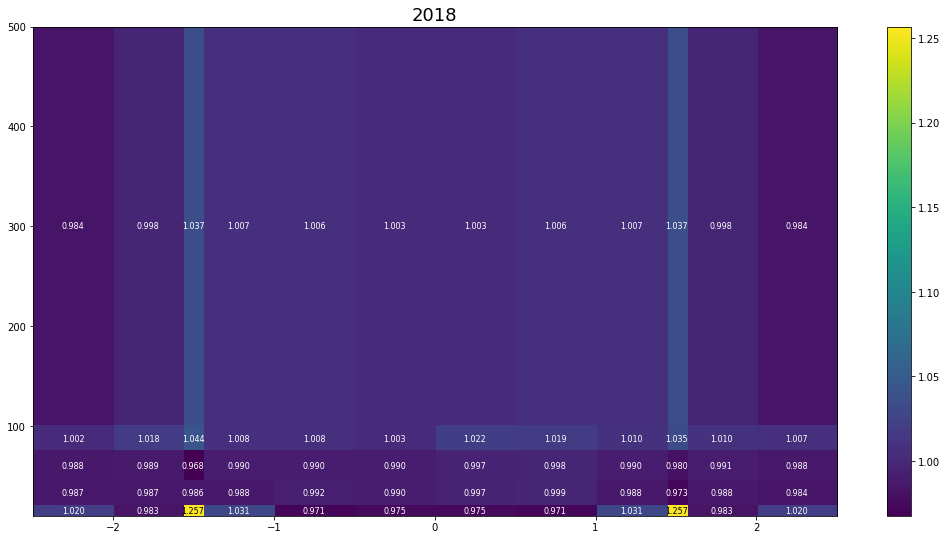

In [19]:
# Get reco eff sf histogram (2018 only has one histogram)
input_file = f"{TTH_SFS_BASE}/2018/electrons/reco/el_scaleFactors_gsf.root"
hist_name = "EGamma_SF2D"
hist = uproot.open(input_file).get(hist_name)
# Plot
fig, ax = plt.subplots(figsize=(18, 9))
c = ax.pcolorfast(hist.edges[0], hist.edges[1], hist.values.T)
cbar = fig.colorbar(c, ax=ax)
bin_text(hist.values.T, hist.edges[0], hist.edges[1], ax, cbar, fmt=":0.3f")
ax.set_title(f"2018", size=18);

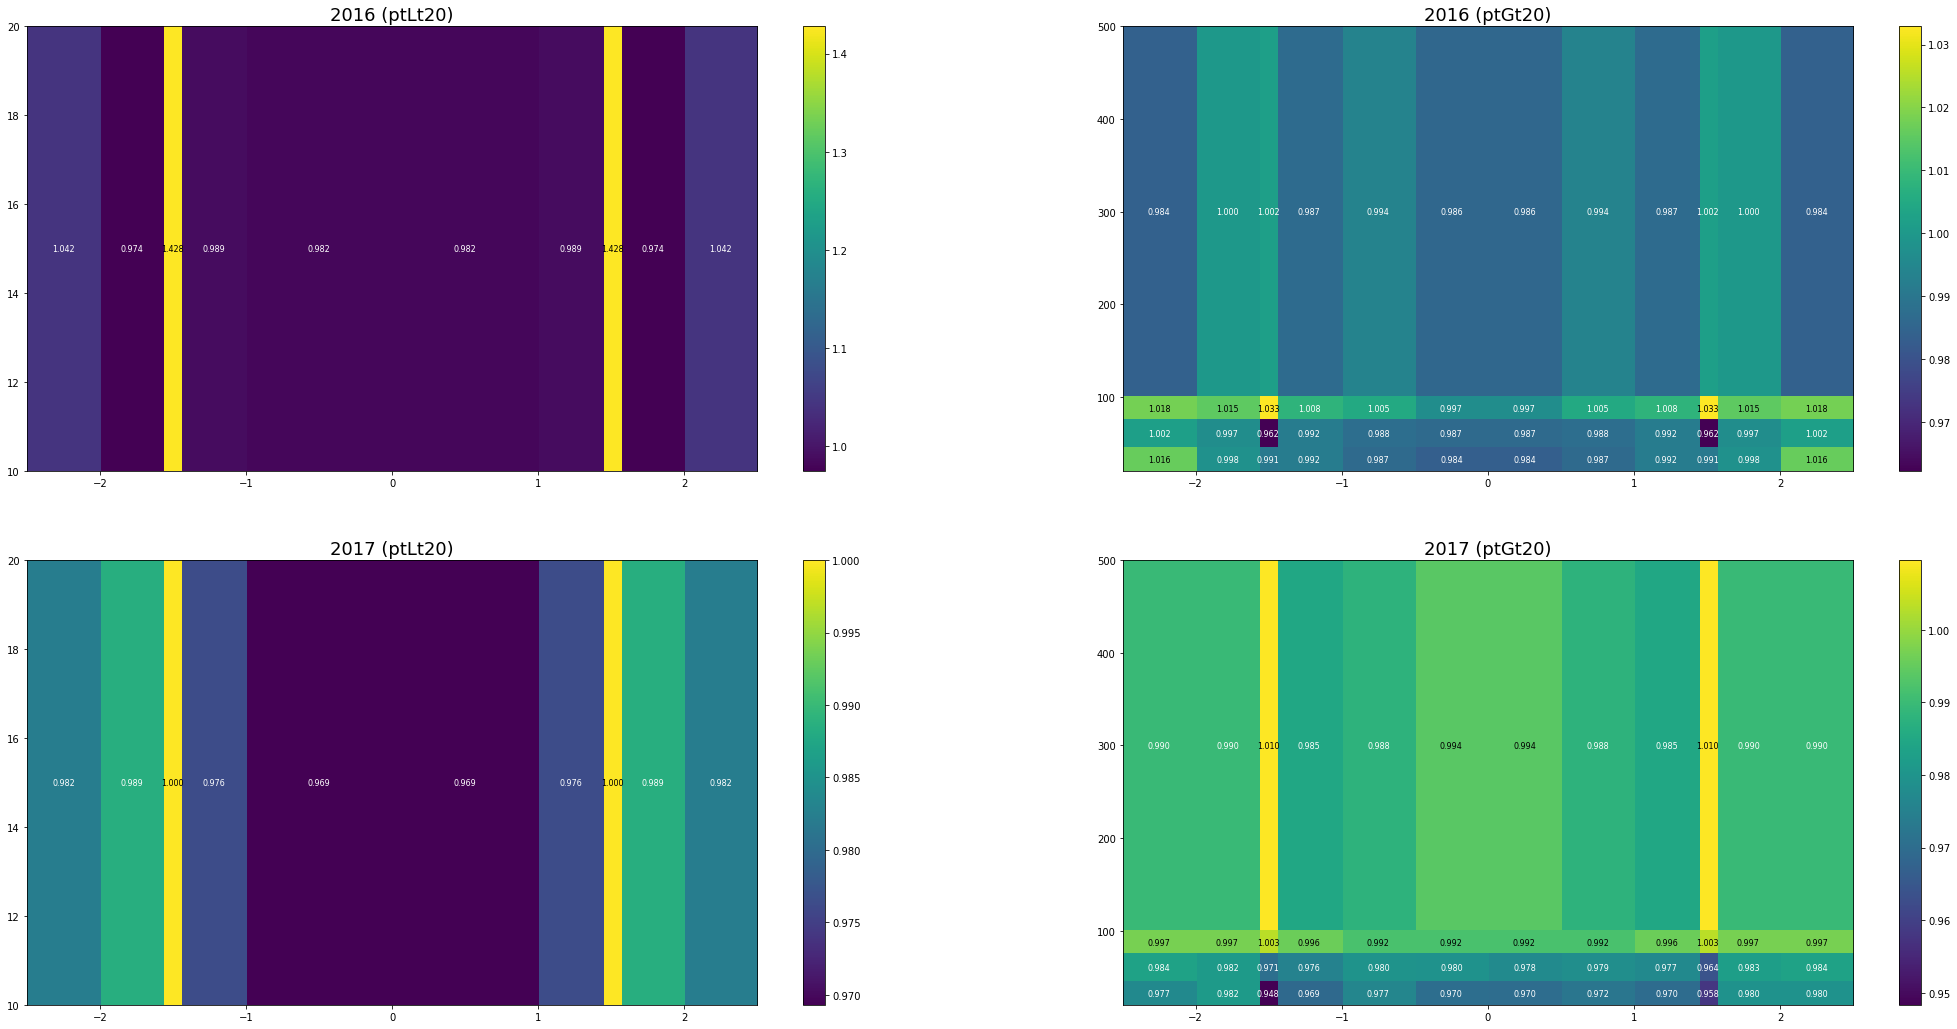

In [20]:
# Set up sanity-check plots
fig, axes = plt.subplots(2, 2, figsize=(36, 18))
for i, year in enumerate(["2016", "2017"]):
    for j, pt_bin in enumerate(["ptLt20", "ptGt20"]):
        # Get reco eff sf histogram (2016 and 2017 have two histograms)
        input_file = f"{TTH_SFS_BASE}/{year}/electrons/reco/el_scaleFactors_gsf_{pt_bin}.root"
        hist_name = "EGamma_SF2D"
        hist = uproot.open(input_file).get(hist_name)
        # Plot for sanity check
        ax = axes[i][j]
        c = ax.pcolorfast(hist.edges[0], hist.edges[1], hist.values.T)
        cbar = fig.colorbar(c, ax=ax)
        bin_text(hist.values.T, hist.edges[0], hist.edges[1], ax, cbar, fmt=":0.3f")
        ax.set_title(f"{year} ({pt_bin})", size=18)